In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [29]:
# Cargar el archivo CSV
df = pd.read_csv("dataset_elpino.csv", sep=";", encoding="utf-8")

# Procesar los nombres de las columnas
new_columns = []
for col in df.columns:
    col_name = col.split("-")[0].strip()
    if col_name.startswith("Diag") or col_name.startswith("Proc"):
        parts = col_name.split(" ")
        if len(parts) > 1:
            col_name = parts[0] + parts[1]
    new_columns.append(col_name)

df.columns = new_columns

print("Datos cargados correctamente.")
print(f"Dimensiones del DataFrame: {df.shape}")

Datos cargados correctamente.
Dimensiones del DataFrame: (14561, 68)


In [31]:
# Función para extraer solo el código de un campo con formato "código - descripción"
def extraer_codigo(texto):
    if pd.isna(texto) or texto == "":
        return ""
    
    # Si hay un guion, tomar solo la parte antes del guion
    if " - " in texto:
        return texto.split(" - ")[0].strip()
    return texto.strip()

# Aplicar la función a todas las columnas de diagnósticos y procedimientos
print("Extrayendo códigos de diagnósticos y procedimientos...")
cols_diag = [col for col in df.columns if col.startswith('Diag')]
cols_proc = [col for col in df.columns if col.startswith('Proced')]

for col in cols_diag + cols_proc:
    df[col] = df[col].apply(extraer_codigo)

# Extraer códigos de GRD
print("Extrayendo códigos de GRD...")
df['GRD'] = df['GRD'].apply(extraer_codigo)

# Reemplazar explícitamente los valores "-" y vacíos por NaN
df = df.replace("-", pd.NA)
df = df.replace("", pd.NA)

# Mostrar las primeras filas después de la extracción de códigos
print("\nPrimeras filas después de extraer códigos:")
display(df.head())

# Verificar valores nulos
print("\nValores nulos por columna:")
null_counts = df.isnull().sum()
display(pd.DataFrame({
    'Columna': null_counts.index,
    'Valores Nulos': null_counts.values,
    'Porcentaje': (null_counts.values / len(df) * 100).round(2)
}).sort_values('Valores Nulos', ascending=False).head(20))

# Verificar específicamente valores en diagnósticos y procedimientos
print("\nEjemplo de valores en columnas de diagnósticos después de la limpieza:")
for col in cols_diag[:3]:  # Mostrar solo las primeras 3 columnas
    print(f"{col}: Valores únicos: {df[col].nunique()}, Nulos: {df[col].isnull().sum()}")
    print(f"Primeros 5 valores no nulos: {df[col].dropna().head().tolist()}")

print("\nEjemplo de valores en columnas de procedimientos después de la limpieza:")
for col in cols_proc[:3]:  # Mostrar solo las primeras 3 columnas
    print(f"{col}: Valores únicos: {df[col].nunique()}, Nulos: {df[col].isnull().sum()}")
    print(f"Primeros 5 valores no nulos: {df[col].dropna().head().tolist()}")

# Verificar valores únicos en GRD después de la limpieza
print("\nEjemplo de valores en GRD después de la limpieza:")
print(f"GRD: Valores únicos: {df['GRD'].nunique()}, Nulos: {df['GRD'].isnull().sum()}")
print(f"Primeros 5 valores de GRD: {df['GRD'].head().tolist()}")

Extrayendo códigos de diagnósticos y procedimientos...
Extrayendo códigos de GRD...

Primeras filas después de extraer códigos:


,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,Edad en años,Sexo (Desc),GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.84,88.72,90.42,90.52,91.39,91.33,87.03,40,Hombre,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.62,90.43,91.39,90.52,91.32,96.59,90.99,53,Hombre,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,99.84,91.73,90.53,99.26,89.39,89.66,89.65,65,Hombre,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,57.94,00.13,00.17,99.04,99.18,99.21,99.23,61,Hombre,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,90.52,91.39,91.32,93.90,99.15,96.59,45.13,30,Hombre,041023



Valores nulos por columna:


,Columna,Valores Nulos,Porcentaje
34,Diag35,14533,99.81
33,Diag34,14521,99.73
32,Diag33,14518,99.70
31,Diag32,14504,99.61
30,Diag31,14494,99.54
29,Diag30,14485,99.48
28,Diag29,14468,99.36
27,Diag28,14451,99.24
26,Diag27,14431,99.11
25,Diag26,14407,98.94



Ejemplo de valores en columnas de diagnósticos después de la limpieza:
Diag01: Valores únicos: 1491, Nulos: 0
Primeros 5 valores no nulos: ['A41.8', 'U07.1', 'K56.5', 'K76.8', 'T81.0']
Diag02: Valores únicos: 1716, Nulos: 1209
Primeros 5 valores no nulos: ['B37.6', 'J12.8', 'R57.2', 'K66.1', 'Y83.2']
Diag03: Valores únicos: 1497, Nulos: 2687
Primeros 5 valores no nulos: ['I39.8', 'R06.0', 'R57.1', 'N18.5', 'S31.1']

Ejemplo de valores en columnas de procedimientos después de la limpieza:
Proced01: Valores únicos: 528, Nulos: 0
Primeros 5 valores no nulos: ['86.28', '31.1', '86.22', '54.19', '54.11']
Proced02: Valores únicos: 495, Nulos: 134
Primeros 5 valores no nulos: ['34.91', '86.28', '54.59', '39.98', '45.90']
Proced03: Valores únicos: 384, Nulos: 342
Primeros 5 valores no nulos: ['88.38', '96.72', '96.72', '86.28', '46.73']

Ejemplo de valores en GRD después de la limpieza:
GRD: Valores únicos: 526, Nulos: 0
Primeros 5 valores de GRD: ['184103', '041013', '041013', '041023', '041

Se encontraron 144 filas duplicadas.
Filas después de eliminar duplicados: 14417

Resumen después de la limpieza:
Filas originales: 14561
Filas después de limpieza: 14417
Diferencia: 144

Número de GRD únicos: 526

Distribución de GRD después de la limpieza (top 10):


GRD
146101    811
146121    637
146131    538
134161    325
071141    317
044153    287
158171    271
061131    252
041023    248
146102    244
Name: count, dtype: int64

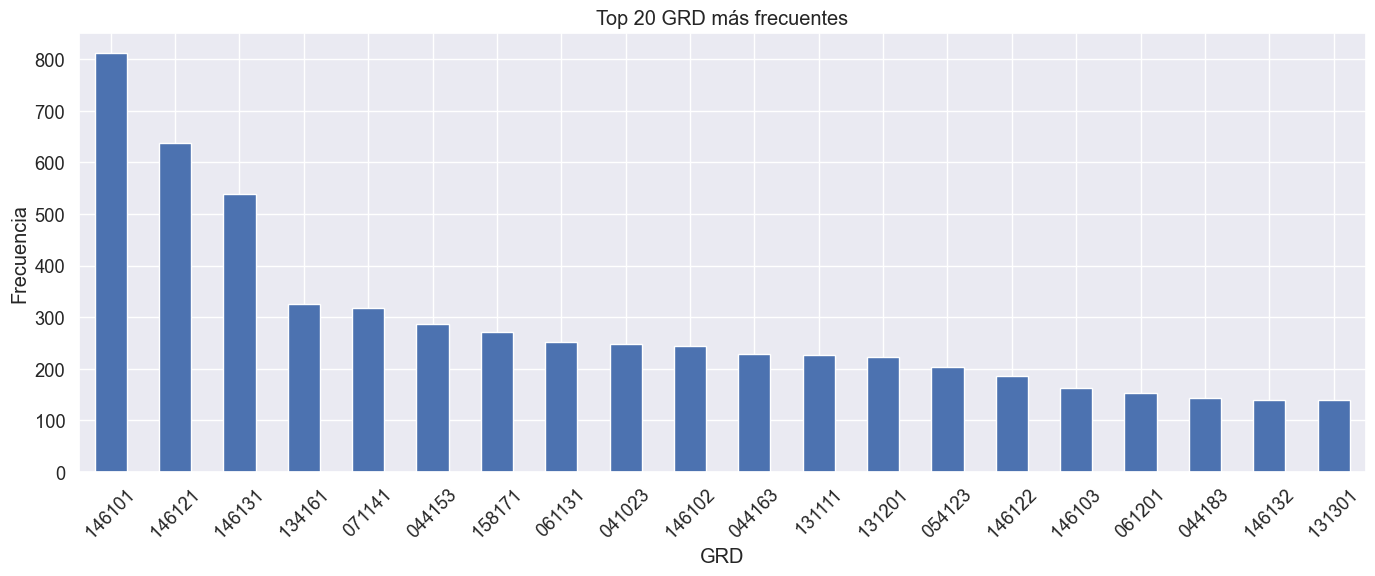

In [33]:
# Función para limpiar el DataFrame
def limpiar_dataframe(df):
    # Crear una copia para no modificar el original
    df_limpio = df.copy()
    
    # 1. Verificar y manejar valores nulos en GRD
    if df_limpio['GRD'].isnull().sum() > 0:
        print(f"Se encontraron {df_limpio['GRD'].isnull().sum()} valores nulos en GRD.")
        # Eliminar filas con GRD nulo
        df_limpio = df_limpio.dropna(subset=['GRD'])
        print(f"Filas después de eliminar GRD nulos: {df_limpio.shape[0]}")
    
    # 2. Manejar valores nulos en diagnósticos y procedimientos
    # Reemplazar NaN con cadena vacía para facilitar el procesamiento
    for col in cols_diag + cols_proc:
        df_limpio[col] = df_limpio[col].fillna("")
    
    # 3. Normalizar códigos
    # Convertir todos los códigos a mayúsculas
    for col in cols_diag + cols_proc:
        df_limpio[col] = df_limpio[col].str.upper()
    
    # 4. Eliminar duplicados exactos
    duplicados = df_limpio.duplicated().sum()
    if duplicados > 0:
        print(f"Se encontraron {duplicados} filas duplicadas.")
        df_limpio = df_limpio.drop_duplicates()
        print(f"Filas después de eliminar duplicados: {df_limpio.shape[0]}")
    
    return df_limpio

# Aplicar limpieza
df_limpio = limpiar_dataframe(df)

# Verificar resultados de la limpieza
print("\nResumen después de la limpieza:")
print(f"Filas originales: {df.shape[0]}")
print(f"Filas después de limpieza: {df_limpio.shape[0]}")
print(f"Diferencia: {df.shape[0] - df_limpio.shape[0]}")

# Verificar valores únicos en GRD
n_grd = df_limpio['GRD'].nunique()
print(f"\nNúmero de GRD únicos: {n_grd}")

# Verificar distribución de GRD después de la limpieza
print("\nDistribución de GRD después de la limpieza (top 10):")
display(df_limpio['GRD'].value_counts().head(10))

# Visualizar la distribución de GRD
plt.figure(figsize=(14, 6))
df_limpio['GRD'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 GRD más frecuentes')
plt.xlabel('GRD')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Número de GRD con frecuencia >= 3: 395
Número de GRD con frecuencia < 3: 131
Registros con GRD frecuentes: 14231 (98.71%)
Registros con GRD poco frecuentes: 186 (1.29%)

Distribución de GRD después de agrupar (top 10 + 'otros' si está entre los top 10):


GRD_agrupado
146101    811
146121    637
146131    538
134161    325
071141    317
044153    287
158171    271
061131    252
041023    248
146102    244
044163    229
Name: count, dtype: int64


La categoría 'otros' contiene 186 registros (1.29% del total)


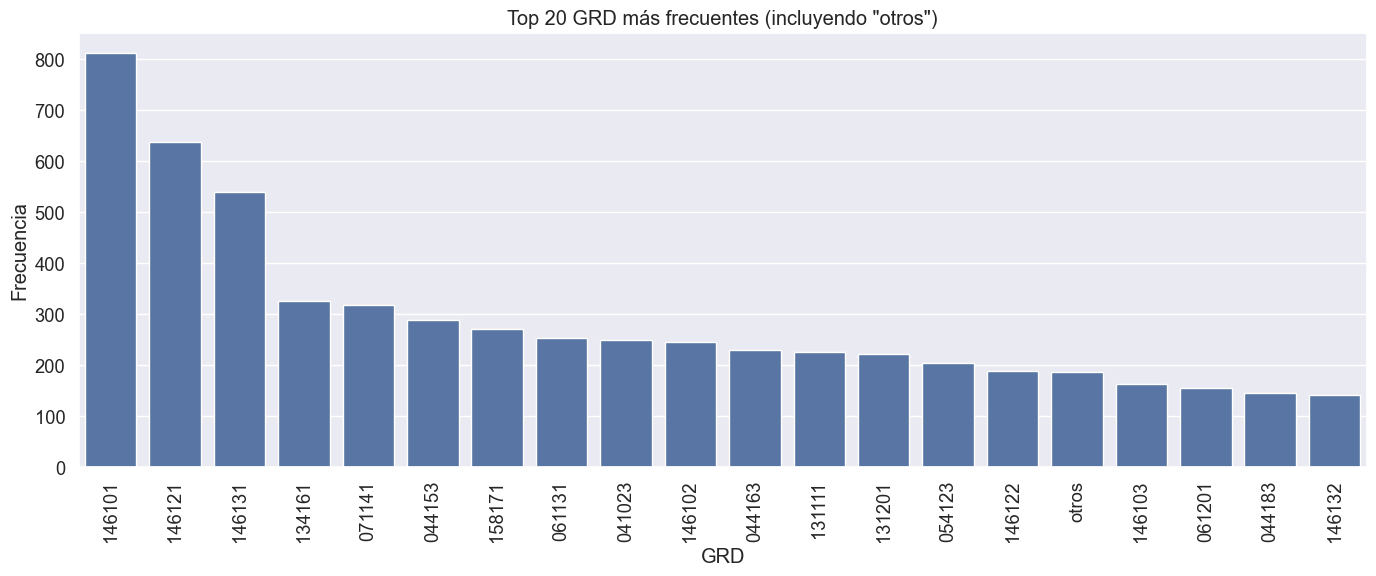

Lista de GRD frecuentes guardada como 'grd_frecuentes.pkl'

Ejemplos de GRD frecuentes (primeros 10):
1. 146101: 811 ocurrencias
2. 146121: 637 ocurrencias
3. 146131: 538 ocurrencias
4. 134161: 325 ocurrencias
5. 071141: 317 ocurrencias
6. 044153: 287 ocurrencias
7. 158171: 271 ocurrencias
8. 061131: 252 ocurrencias
9. 041023: 248 ocurrencias
10. 146102: 244 ocurrencias


In [37]:
# Identificar GRD con frecuencia >= 3
grd_counts = df_limpio['GRD'].value_counts()
grd_frecuentes = grd_counts[grd_counts >= 3].index.tolist()

print(f"Número de GRD con frecuencia >= 3: {len(grd_frecuentes)}")
print(f"Número de GRD con frecuencia < 3: {df_limpio['GRD'].nunique() - len(grd_frecuentes)}")

# Calcular porcentaje de datos cubiertos por GRD frecuentes
n_registros_frecuentes = sum(grd_counts[grd_counts >= 3])
porcentaje_cobertura = (n_registros_frecuentes / len(df_limpio)) * 100

print(f"Registros con GRD frecuentes: {n_registros_frecuentes} ({porcentaje_cobertura:.2f}%)")
print(f"Registros con GRD poco frecuentes: {len(df_limpio) - n_registros_frecuentes} ({100-porcentaje_cobertura:.2f}%)")

# Crear una nueva columna para GRD agrupados
df_limpio['GRD_agrupado'] = df_limpio['GRD'].apply(lambda x: x if x in grd_frecuentes else "otros")

# Verificar la distribución después de agrupar
print("\nDistribución de GRD después de agrupar (top 10 + 'otros' si está entre los top 10):")
display(df_limpio['GRD_agrupado'].value_counts().head(11))

# Calcular el porcentaje de la categoría "otros"
otros_count = df_limpio['GRD_agrupado'].value_counts().get('otros', 0)
otros_porcentaje = (otros_count / len(df_limpio)) * 100
print(f"\nLa categoría 'otros' contiene {otros_count} registros ({otros_porcentaje:.2f}% del total)")

# Visualizar la nueva distribución
plt.figure(figsize=(14, 6))
top_grds = df_limpio['GRD_agrupado'].value_counts().head(20)
sns.barplot(x=top_grds.index, y=top_grds.values)
plt.title('Top 20 GRD más frecuentes (incluyendo "otros")')
plt.xlabel('GRD')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Guardar la lista de GRD frecuentes para uso futuro
with open('grd_frecuentes.pkl', 'wb') as f:
    pickle.dump(grd_frecuentes, f)

print("Lista de GRD frecuentes guardada como 'grd_frecuentes.pkl'")

# Mostrar algunos ejemplos de GRD frecuentes
print("\nEjemplos de GRD frecuentes (primeros 10):")
for i, grd in enumerate(grd_frecuentes[:10]):
    count = grd_counts[grd]
    print(f"{i+1}. {grd}: {count} ocurrencias")

Número de clases: 396
Primeras 5 clases: ['014112' '014113' '014131' '014132' '014133']
Clase 'otros' tiene el índice: 395

Tamaño del conjunto de entrenamiento: (10091, 65)
Tamaño del conjunto de prueba: (4326, 65)

Distribución de clases en entrenamiento (top 5):


146101    0.056288
146121    0.044198
146131    0.037360
134161    0.022495
071141    0.022000
Name: proportion, dtype: float64


Distribución de clases en prueba (top 5):


146101    0.056172
146121    0.044152
146131    0.037217
134161    0.022654
071141    0.021960
Name: proportion, dtype: float64

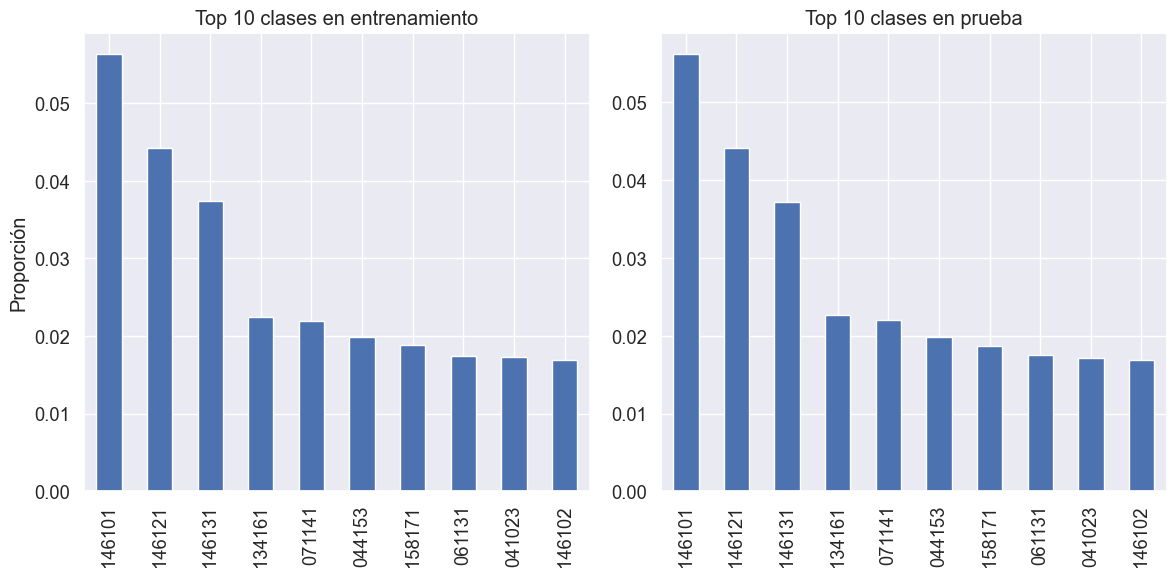


Proporción de la clase 'otros':
  - En entrenamiento: 1.29%
  - En prueba: 1.29%


In [39]:
# Preparar X e y
# Seleccionar solo las columnas de diagnósticos y procedimientos
X = df_limpio[cols_diag + cols_proc]
y = df_limpio['GRD_agrupado']

# Codificar la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Guardar el codificador para uso futuro
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print(f"Número de clases: {len(label_encoder.classes_)}")
print(f"Primeras 5 clases: {label_encoder.classes_[:5]}")
print(f"Clase 'otros' tiene el índice: {list(label_encoder.classes_).index('otros') if 'otros' in label_encoder.classes_ else 'No encontrado'}")

# Dividir en conjuntos de entrenamiento y prueba con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.3, 
    random_state=RANDOM_SEED, 
    stratify=y_encoded  # Asegura distribución proporcional de clases
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Verificar la distribución de clases en los conjuntos de entrenamiento y prueba
train_class_dist = pd.Series(y_train).map(lambda x: label_encoder.classes_[x]).value_counts(normalize=True)
test_class_dist = pd.Series(y_test).map(lambda x: label_encoder.classes_[x]).value_counts(normalize=True)

print("\nDistribución de clases en entrenamiento (top 5):")
display(train_class_dist.head())

print("\nDistribución de clases en prueba (top 5):")
display(test_class_dist.head())

# Verificar que la estratificación funcionó correctamente
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
train_class_dist.head(10).plot(kind='bar')
plt.title('Top 10 clases en entrenamiento')
plt.ylabel('Proporción')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
test_class_dist.head(10).plot(kind='bar')
plt.title('Top 10 clases en prueba')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Verificar la proporción de la clase "otros" en ambos conjuntos
if 'otros' in label_encoder.classes_:
    otros_idx = list(label_encoder.classes_).index('otros')
    otros_train = (y_train == otros_idx).sum() / len(y_train) * 100
    otros_test = (y_test == otros_idx).sum() / len(y_test) * 100
    print(f"\nProporción de la clase 'otros':")
    print(f"  - En entrenamiento: {otros_train:.2f}%")
    print(f"  - En prueba: {otros_test:.2f}%")

In [47]:
# Función para crear características híbridas
def crear_caracteristicas_hibridas(X_train, X_test, y_train, cols_diag, cols_proc):
    """
    Crea características híbridas combinando:
    1. Características binarias para códigos importantes
    2. Características de categoría
    3. Características específicas para primeros diagnósticos/procedimientos
    """
    start_time = time.time()
    print("Iniciando creación de características híbridas...")
    
    # Características binarias para códigos importantes
    codigos_importantes = {}
    umbral = 5  # Umbral de frecuencia mínima
    
    # Para cada clase
    for clase in np.unique(y_train):
        indices = np.where(y_train == clase)[0]
        subset = X_train.iloc[indices]
        
        # Contar frecuencias de códigos en diagnósticos
        for col in cols_diag:
            counter = Counter(subset[col])
            for codigo, freq in counter.items():
                if freq >= umbral and codigo != "":
                    if codigo not in codigos_importantes:
                        codigos_importantes[codigo] = 0
                    codigos_importantes[codigo] += freq
        
        # Contar frecuencias de códigos en procedimientos
        for col in cols_proc:
            counter = Counter(subset[col])
            for codigo, freq in counter.items():
                if freq >= umbral and codigo != "":
                    if codigo not in codigos_importantes:
                        codigos_importantes[codigo] = 0
                    codigos_importantes[codigo] += freq
    
    # Seleccionar los top N códigos más frecuentes
    top_n = 100
    top_codigos = sorted(codigos_importantes.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_codigos = [codigo for codigo, _ in top_codigos]
    
    print(f"Número de códigos importantes seleccionados: {len(top_codigos)}")
    
    # Crear matrices binarias
    X_train_bin = np.zeros((len(X_train), len(top_codigos)))
    X_test_bin = np.zeros((len(X_test), len(top_codigos)))
    
    # Llenar matrices
    for i, (_, row) in enumerate(X_train.iterrows()):
        for j, codigo in enumerate(top_codigos):
            # Verificar si el código está presente en alguna columna
            for col in cols_diag + cols_proc:
                if row[col] == codigo:
                    X_train_bin[i, j] = 1
                    break
    
    for i, (_, row) in enumerate(X_test.iterrows()):
        for j, codigo in enumerate(top_codigos):
            # Verificar si el código está presente en alguna columna
            for col in cols_diag + cols_proc:
                if row[col] == codigo:
                    X_test_bin[i, j] = 1
                    break
    
    # Características de categoría
    # Función para extraer categoría de un código
    def extraer_categoria(codigo):
        if not codigo or codigo == "":
            return "VACIO"
        # Para códigos ICD-10, la categoría suele ser la letra inicial + primeros dígitos
        if codigo[0].isalpha():
            return codigo[0:2]  # Ejemplo: I10 -> I1
        # Para otros tipos de códigos, usar los primeros 2 caracteres
        return codigo[:2]
    
    # Identificar todas las categorías únicas
    categorias = set()
    for _, row in X_train.iterrows():
        for col in cols_diag + cols_proc:
            if row[col] != "":
                categorias.add(extraer_categoria(row[col]))
    
    categorias = list(categorias)
    print(f"Número de categorías únicas: {len(categorias)}")
    
    # Crear matrices de conteo por categoría
    X_train_cat = np.zeros((len(X_train), len(categorias)))
    X_test_cat = np.zeros((len(X_test), len(categorias)))
    
    # Llenar matrices
    for i, (_, row) in enumerate(X_train.iterrows()):
        for col in cols_diag + cols_proc:
            if row[col] != "":
                cat = extraer_categoria(row[col])
                if cat in categorias:
                    idx = categorias.index(cat)
                    X_train_cat[i, idx] += 1
    
    for i, (_, row) in enumerate(X_test.iterrows()):
        for col in cols_diag + cols_proc:
            if row[col] != "":
                cat = extraer_categoria(row[col])
                if cat in categorias:
                    idx = categorias.index(cat)
                    X_test_cat[i, idx] += 1
    
    # Características específicas para primeros diagnósticos/procedimientos
    primeros_diag = min(3, len(cols_diag))  # Primeros 3 diagnósticos
    primeros_proc = min(3, len(cols_proc))  # Primeros 3 procedimientos
    
    # Recopilar códigos únicos para los primeros diagnósticos/procedimientos
    primeros_codigos = set()
    for _, row in X_train.iterrows():
        for i in range(primeros_diag):
            if i < len(cols_diag) and row[cols_diag[i]] != "":
                primeros_codigos.add(row[cols_diag[i]])
        for i in range(primeros_proc):
            if i < len(cols_proc) and row[cols_proc[i]] != "":
                primeros_codigos.add(row[cols_proc[i]])
    
    primeros_codigos = list(primeros_codigos)
    print(f"Número de códigos únicos en primeros diagnósticos/procedimientos: {len(primeros_codigos)}")
    
    # Limitar a los más frecuentes para evitar demasiadas características
    max_primeros_codigos = 100
    if len(primeros_codigos) > max_primeros_codigos:
        # Contar frecuencias
        counter = Counter()
        for _, row in X_train.iterrows():
            for i in range(primeros_diag):
                if i < len(cols_diag) and row[cols_diag[i]] != "":
                    counter[row[cols_diag[i]]] += 1
            for i in range(primeros_proc):
                if i < len(cols_proc) and row[cols_proc[i]] != "":
                    counter[row[cols_proc[i]]] += 1
        
        # Seleccionar los más frecuentes
        primeros_codigos = [codigo for codigo, _ in counter.most_common(max_primeros_codigos)]
    
    # Crear matrices para primeros diagnósticos/procedimientos
    X_train_primeros = np.zeros((len(X_train), len(primeros_codigos)))
    X_test_primeros = np.zeros((len(X_test), len(primeros_codigos)))
    
    # Llenar matrices
    for i, (_, row) in enumerate(X_train.iterrows()):
        for j in range(primeros_diag):
            if j < len(cols_diag) and row[cols_diag[j]] in primeros_codigos:
                idx = primeros_codigos.index(row[cols_diag[j]])
                X_train_primeros[i, idx] = 1
        for j in range(primeros_proc):
            if j < len(cols_proc) and row[cols_proc[j]] in primeros_codigos:
                idx = primeros_codigos.index(row[cols_proc[j]])
                X_train_primeros[i, idx] = 1
    
    for i, (_, row) in enumerate(X_test.iterrows()):
        for j in range(primeros_diag):
            if j < len(cols_diag) and row[cols_diag[j]] in primeros_codigos:
                idx = primeros_codigos.index(row[cols_diag[j]])
                X_test_primeros[i, idx] = 1
        for j in range(primeros_proc):
            if j < len(cols_proc) and row[cols_proc[j]] in primeros_codigos:
                idx = primeros_codigos.index(row[cols_proc[j]])
                X_test_primeros[i, idx] = 1
    
    # Combinar todas las características
    X_train_combined = np.hstack((X_train_bin, X_train_cat, X_train_primeros))
    X_test_combined = np.hstack((X_test_bin, X_test_cat, X_test_primeros))
    
    print(f"Forma final de X_train_combined: {X_train_combined.shape}")
    print(f"Forma final de X_test_combined: {X_test_combined.shape}")
    
    # Selección de características (opcional)
    print("Aplicando selección de características...")
    selector = SelectKBest(f_classif, k=min(1000, X_train_combined.shape[1]))
    X_train_selected = selector.fit_transform(X_train_combined, y_train)
    X_test_selected = selector.transform(X_test_combined)
    
    print(f"Forma después de selección: X_train_selected: {X_train_selected.shape}")
    
    # Información sobre las características
    feature_info = {
        'top_codigos': top_codigos,
        'categorias': categorias,
        'primeros_codigos': primeros_codigos,
        'n_bin': X_train_bin.shape[1],
        'n_cat': X_train_cat.shape[1],
        'n_primeros': X_train_primeros.shape[1],
        'selector': selector
    }
    
    # Guardar información de características para uso futuro
    with open('feature_info.pkl', 'wb') as f:
        pickle.dump(feature_info, f)
    
    elapsed_time = time.time() - start_time
    print(f"Tiempo total para crear características: {elapsed_time:.2f} segundos")
    
    return X_train_selected, X_test_selected, feature_info

# Aplicar la función para crear características
X_train_features, X_test_features, feature_info = crear_caracteristicas_hibridas(
    X_train, X_test, y_train, cols_diag, cols_proc
)

# Guardar las características para no tener que recalcularlas
np.save('X_train_features.npy', X_train_features)
np.save('X_test_features.npy', X_test_features)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

print("Características guardadas en archivos .npy")

Iniciando creación de características híbridas...
Número de códigos importantes seleccionados: 100
Número de categorías únicas: 315
Número de códigos únicos en primeros diagnósticos/procedimientos: 3110
Forma final de X_train_combined: (10091, 515)
Forma final de X_test_combined: (4326, 515)
Aplicando selección de características...
Forma después de selección: X_train_selected: (10091, 515)
Tiempo total para crear características: 396.88 segundos
Características guardadas en archivos .npy


Entrenando Árbol de Decisión...


C:\Users\cduty\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas para Árbol de Decisión:
  Accuracy: 0.4043
  Precision: 0.4245
  Recall: 0.4043
  F1-Score: 0.3903
Tiempo total para entrenar y evaluar el Árbol de Decisión: 0.74 segundos
Modelo guardado como 'arbol_decision_model.pkl'


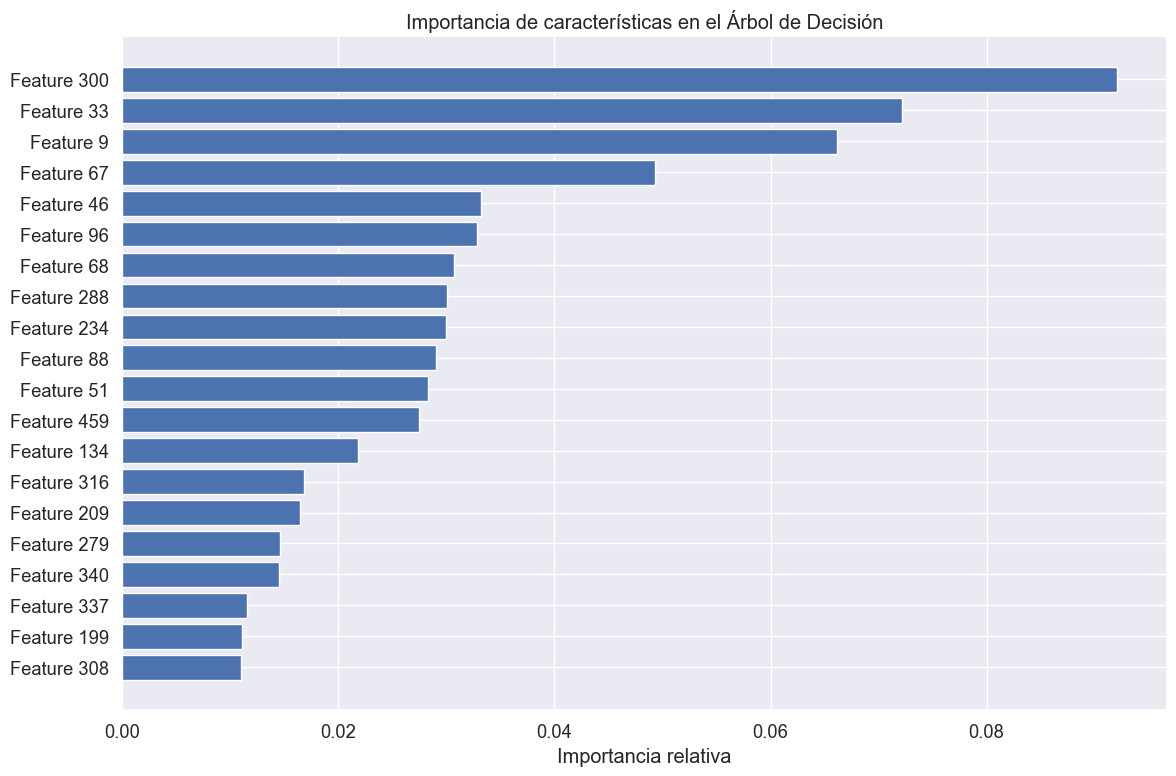

In [49]:
# Arbol de Decision
def evaluar_modelo(y_true, y_pred, nombre_modelo):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"Métricas para {nombre_modelo}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Entrenar Árbol de Decisión
print("Entrenando Árbol de Decisión...")
start_time = time.time()

# Crear y entrenar el modelo
dt_classifier = DecisionTreeClassifier(
    max_depth=20,          # Profundidad máxima del árbol
    min_samples_split=5,   # Mínimo de muestras para dividir un nodo
    min_samples_leaf=2,    # Mínimo de muestras en un nodo hoja
    random_state=RANDOM_SEED
)

dt_classifier.fit(X_train_features, y_train)

# Evaluar el modelo
y_pred_dt = dt_classifier.predict(X_test_features)
metricas_dt = evaluar_modelo(y_test, y_pred_dt, "Árbol de Decisión")

# Guardar el modelo
with open('arbol_decision_model.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

elapsed_time = time.time() - start_time
print(f"Tiempo total para entrenar y evaluar el Árbol de Decisión: {elapsed_time:.2f} segundos")
print("Modelo guardado como 'arbol_decision_model.pkl'")

# Visualizar importancia de características (top 20)
if hasattr(dt_classifier, 'feature_importances_'):
    importances = dt_classifier.feature_importances_
    indices = np.argsort(importances)[-20:]  # Top 20 características
    
    plt.figure(figsize=(12, 8))
    plt.title('Importancia de características en el Árbol de Decisión')
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    plt.xlabel('Importancia relativa')
    plt.tight_layout()
    plt.show()

Entrenando Red Neuronal...


C:\Users\cduty\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Métricas para Red Neuronal:
  Accuracy: 0.6297
  Precision: 0.6159
  Recall: 0.6297
  F1-Score: 0.6124
Tiempo total para entrenar y evaluar la Red Neuronal: 39.02 segundos
Modelo guardado como 'red_neuronal_model.pkl'


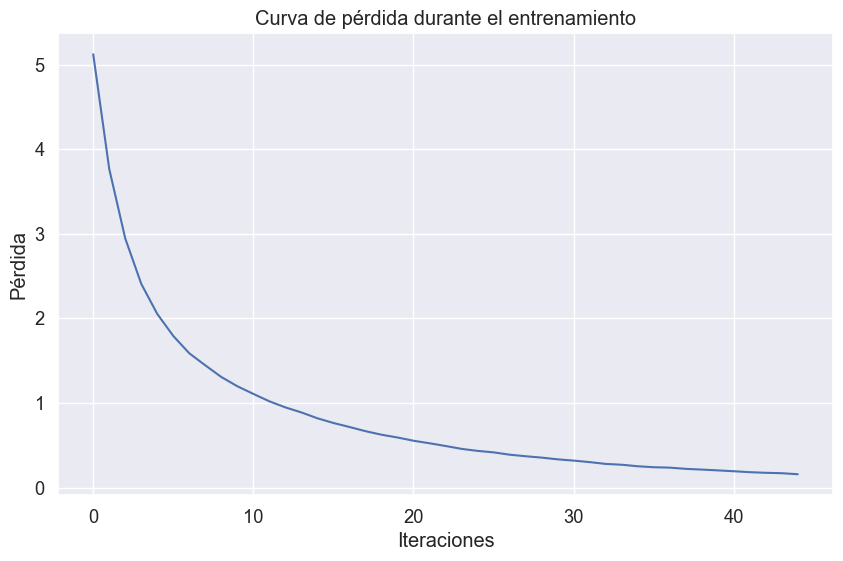

In [51]:
# Entrenar Red Neuronal
print("Entrenando Red Neuronal...")
start_time = time.time()

# Crear y entrenar el modelo
nn_classifier = MLPClassifier(
    hidden_layer_sizes=(200, 100),  # Dos capas ocultas
    activation='relu',              # Función de activación
    solver='adam',                  # Optimizador
    alpha=0.0001,                   # Regularización L2
    batch_size=256,                 # Tamaño del lote
    learning_rate='adaptive',       # Tasa de aprendizaje adaptativa
    max_iter=300,                   # Máximo de iteraciones
    early_stopping=True,            # Detención temprana
    validation_fraction=0.1,        # Fracción para validación
    random_state=RANDOM_SEED
)

nn_classifier.fit(X_train_features, y_train)

# Evaluar el modelo
y_pred_nn = nn_classifier.predict(X_test_features)
metricas_nn = evaluar_modelo(y_test, y_pred_nn, "Red Neuronal")

# Guardar el modelo
with open('red_neuronal_model.pkl', 'wb') as f:
    pickle.dump(nn_classifier, f)

elapsed_time = time.time() - start_time
print(f"Tiempo total para entrenar y evaluar la Red Neuronal: {elapsed_time:.2f} segundos")
print("Modelo guardado como 'red_neuronal_model.pkl'")

# Visualizar la curva de aprendizaje si está disponible
if hasattr(nn_classifier, 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(nn_classifier.loss_curve_)
    plt.title('Curva de pérdida durante el entrenamiento')
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.show()

Comparación de modelos:


,Modelo,Accuracy,Precision,Recall,F1-Score
0,Árbol de Decisión,0.404300,0.424531,0.404300,0.390261
1,Red Neuronal,0.629681,0.615907,0.629681,0.612358


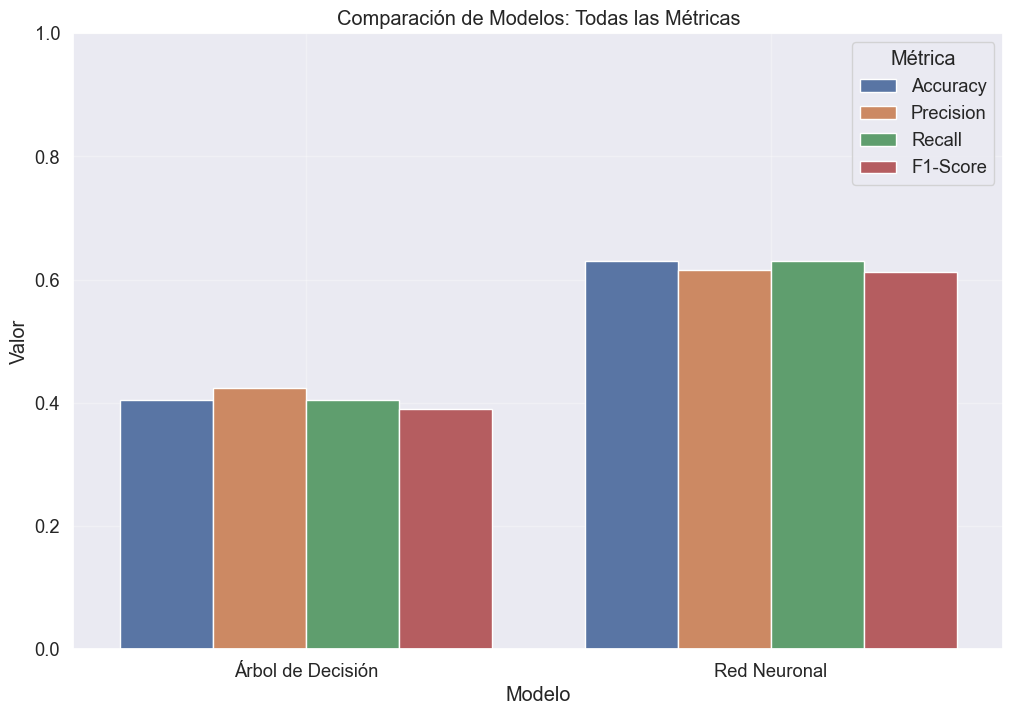


El mejor modelo es: Red Neuronal con F1-Score: 0.6124
Mejor modelo guardado como 'mejor_modelo.pkl'


In [53]:
# Comparar modelos
modelos = {
    'Árbol de Decisión': {
        'modelo': dt_classifier,
        'predicciones': y_pred_dt,
        'metricas': metricas_dt
    },
    'Red Neuronal': {
        'modelo': nn_classifier,
        'predicciones': y_pred_nn,
        'metricas': metricas_nn
    }
}

# Crear DataFrame para comparación
metricas_df = pd.DataFrame({
    'Modelo': ['Árbol de Decisión', 'Red Neuronal'],
    'Accuracy': [metricas_dt['accuracy'], metricas_nn['accuracy']],
    'Precision': [metricas_dt['precision'], metricas_nn['precision']],
    'Recall': [metricas_dt['recall'], metricas_nn['recall']],
    'F1-Score': [metricas_dt['f1'], metricas_nn['f1']]
})

print("Comparación de modelos:")
display(metricas_df)

# Visualizar comparación
plt.figure(figsize=(12, 8))
metricas_df_melted = pd.melt(metricas_df, id_vars=['Modelo'], var_name='Métrica', value_name='Valor')
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=metricas_df_melted)
plt.title('Comparación de Modelos: Todas las Métricas')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.grid(True, alpha=0.3)
plt.show()

# Determinar el mejor modelo basado en F1-Score
mejor_modelo_nombre = metricas_df.loc[metricas_df['F1-Score'].idxmax(), 'Modelo']
mejor_modelo = modelos[mejor_modelo_nombre]['modelo']
mejor_predicciones = modelos[mejor_modelo_nombre]['predicciones']

print(f"\nEl mejor modelo es: {mejor_modelo_nombre} con F1-Score: {modelos[mejor_modelo_nombre]['metricas']['f1']:.4f}")

# Guardar el mejor modelo
with open('mejor_modelo.pkl', 'wb') as f:
    pickle.dump({
        'nombre': mejor_modelo_nombre,
        'modelo': mejor_modelo,
        'metricas': modelos[mejor_modelo_nombre]['metricas'],
        'feature_info': feature_info,
        'label_encoder': label_encoder
    }, f)

print("Mejor modelo guardado como 'mejor_modelo.pkl'")

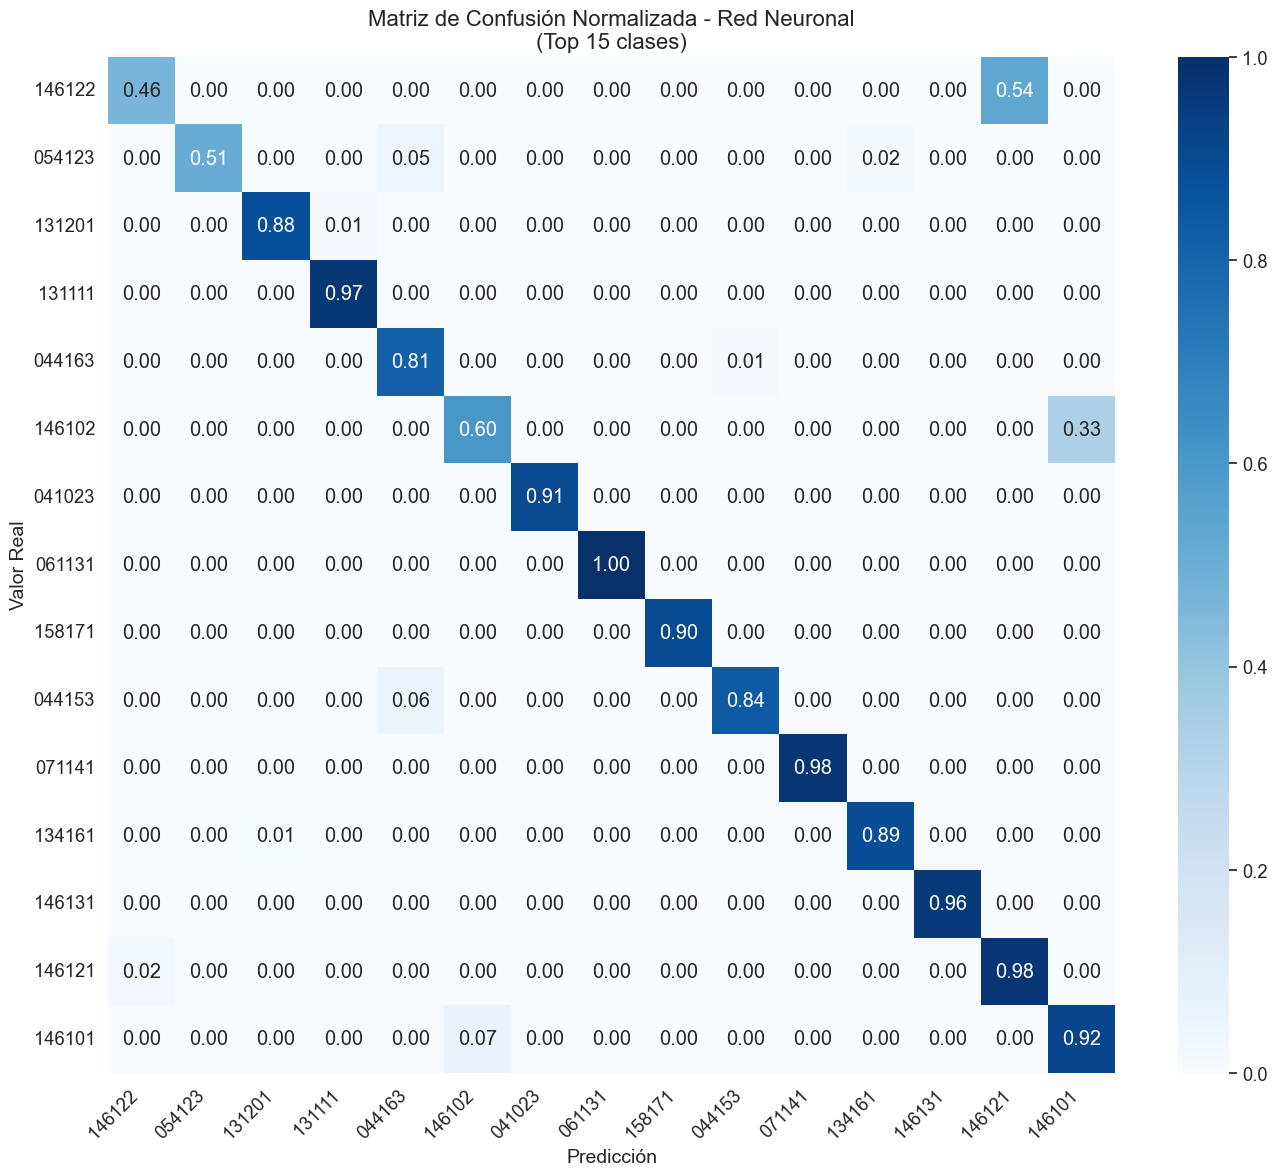

Clases segun F1 - Score


C:\Users\cduty\AppData\Local\Temp\ipykernel_10308\3093111350.py:28: RuntimeWarning: invalid value encountered in divide
  precision_por_clase = np.diag(cm) / np.sum(cm, axis=0)
C:\Users\cduty\AppData\Local\Temp\ipykernel_10308\3093111350.py:34: RuntimeWarning: invalid value encountered in divide
  f1_por_clase = 2 * (precision_por_clase * recall_por_clase) / (precision_por_clase + recall_por_clase)


,GRD,Precisión,Recall,F1-Score,Muestras
71,051063,1.000000,1.000000,1.000000,1
26,031201,1.000000,1.000000,1.000000,1
206,091202,1.000000,1.000000,1.000000,1
333,161201,1.000000,1.000000,1.000000,3
119,061131,0.950000,1.000000,0.974359,76
212,091402,0.928571,1.000000,0.962963,13
211,091401,0.942857,0.970588,0.956522,34
307,146123,0.965517,0.933333,0.949153,30
308,146131,0.901163,0.962733,0.930931,161
269,131111,0.857143,0.970588,0.910345,68


C:\Users\cduty\AppData\Local\Temp\ipykernel_10308\3093111350.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='GRD', data=top_20_f1, palette='viridis')


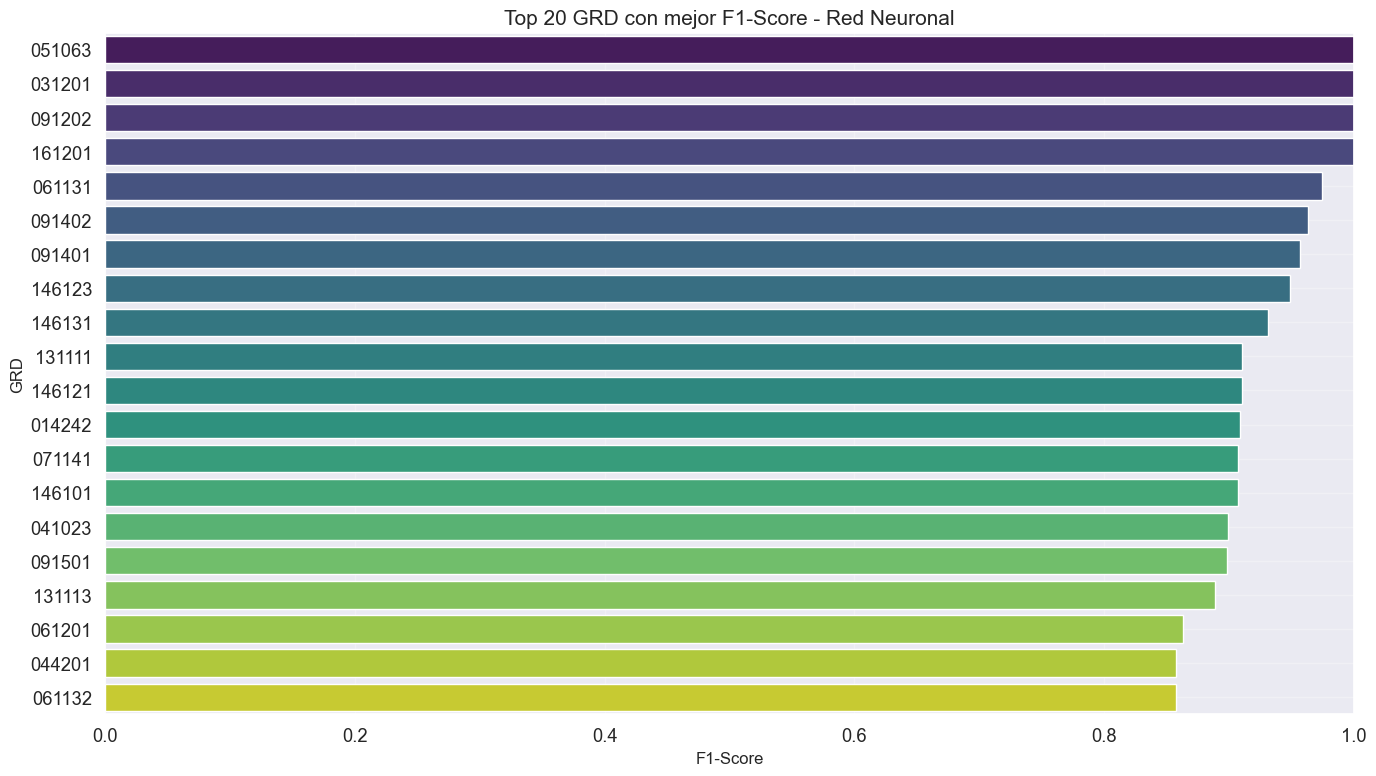


Confusiones más comunes:
  146122 confundido con 146121: 30 veces
  146102 confundido con 146101: 24 veces
  134162 confundido con 134161: 18 veces
  014241 confundido con 094131: 17 veces
  146101 confundido con 146102: 16 veces
  146132 confundido con 146131: 15 veces
  044213 confundido con 044183: 10 veces
  094131 confundido con 014241: 10 veces
  061121 confundido con 061141: 9 veces
  041203 confundido con 041202: 7 veces


In [61]:
# Matriz de confusión para el mejor modelo
cm = confusion_matrix(y_test, mejor_predicciones)

# Normalizar para mejor visualización
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Seleccionar las top N clases más frecuentes para visualizar
top_n_classes = 15
class_counts = np.sum(cm, axis=1)
top_classes_idx = np.argsort(class_counts)[-top_n_classes:]
cm_top = cm[top_classes_idx][:, top_classes_idx]
cm_norm_top = cm_norm[top_classes_idx][:, top_classes_idx]
class_names_top = [label_encoder.classes_[i] for i in top_classes_idx]

# Visualizar matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(cm_norm_top, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names_top, yticklabels=class_names_top)
plt.title(f'Matriz de Confusión Normalizada - {mejor_modelo_nombre}\n(Top {top_n_classes} clases)', fontsize=16)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Valor Real', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Análisis de precisión y recall por clase
precision_por_clase = np.diag(cm) / np.sum(cm, axis=0)
precision_por_clase = np.nan_to_num(precision_por_clase)  # Manejar divisiones por cero

recall_por_clase = np.diag(cm) / np.sum(cm, axis=1)
recall_por_clase = np.nan_to_num(recall_por_clase)  # Manejar divisiones por cero

f1_por_clase = 2 * (precision_por_clase * recall_por_clase) / (precision_por_clase + recall_por_clase)
f1_por_clase = np.nan_to_num(f1_por_clase)  # Manejar divisiones por cero

# Crear DataFrame para análisis por clase
clases_df = pd.DataFrame({
    'GRD': label_encoder.classes_,
    'Precisión': precision_por_clase,
    'Recall': recall_por_clase,
    'F1-Score': f1_por_clase,
    'Muestras': np.sum(cm, axis=1)
})

# Ordenar por F1-Score (de mayor a menor)
clases_df = clases_df.sort_values('F1-Score', ascending=False)

# Mostrar las clases según F1-Score
print("Clases segun F1 - Score")
display(clases_df.head(20))

# print("\nTop 10 clases con peor F1-Score (con al menos 10 muestras):")
# display(clases_df[clases_df['Muestras'] >= 10].tail(10))

# Visualizar F1-Score por clase (top 20)
plt.figure(figsize=(14, 8))
top_20_f1 = clases_df.head(20)
sns.barplot(x='F1-Score', y='GRD', data=top_20_f1, palette='viridis')
plt.title(f'Top 20 GRD con mejor F1-Score - {mejor_modelo_nombre}', fontsize=15)
plt.xlabel('F1-Score', fontsize=12)
plt.ylabel('GRD', fontsize=12)
plt.xlim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Análisis de errores: identificar confusiones comunes
print("\nConfusiones más comunes:")
confusions = []
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        if i != j:  # Excluir la diagonal (predicciones correctas)
            confusions.append((i, j, cm[i, j]))

# Ordenar por número de confusiones
confusions.sort(key=lambda x: x[2], reverse=True)
top_confusions = confusions[:10]

for i, j, count in top_confusions:
    if count > 0:
        print(f"  {label_encoder.classes_[i]} confundido con {label_encoder.classes_[j]}: {count} veces")

C:\Users\cduty\AppData\Local\Temp\ipykernel_10308\2182313082.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=modelos_nombres, x=f1_values, palette=['#3498db', '#2ecc71'], orient='h')
C:\Users\cduty\AppData\Local\Temp\ipykernel_10308\2182313082.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=modelos_nombres, x=mejora_porcentual, palette=['#3498db', '#2ecc71'], orient='h')


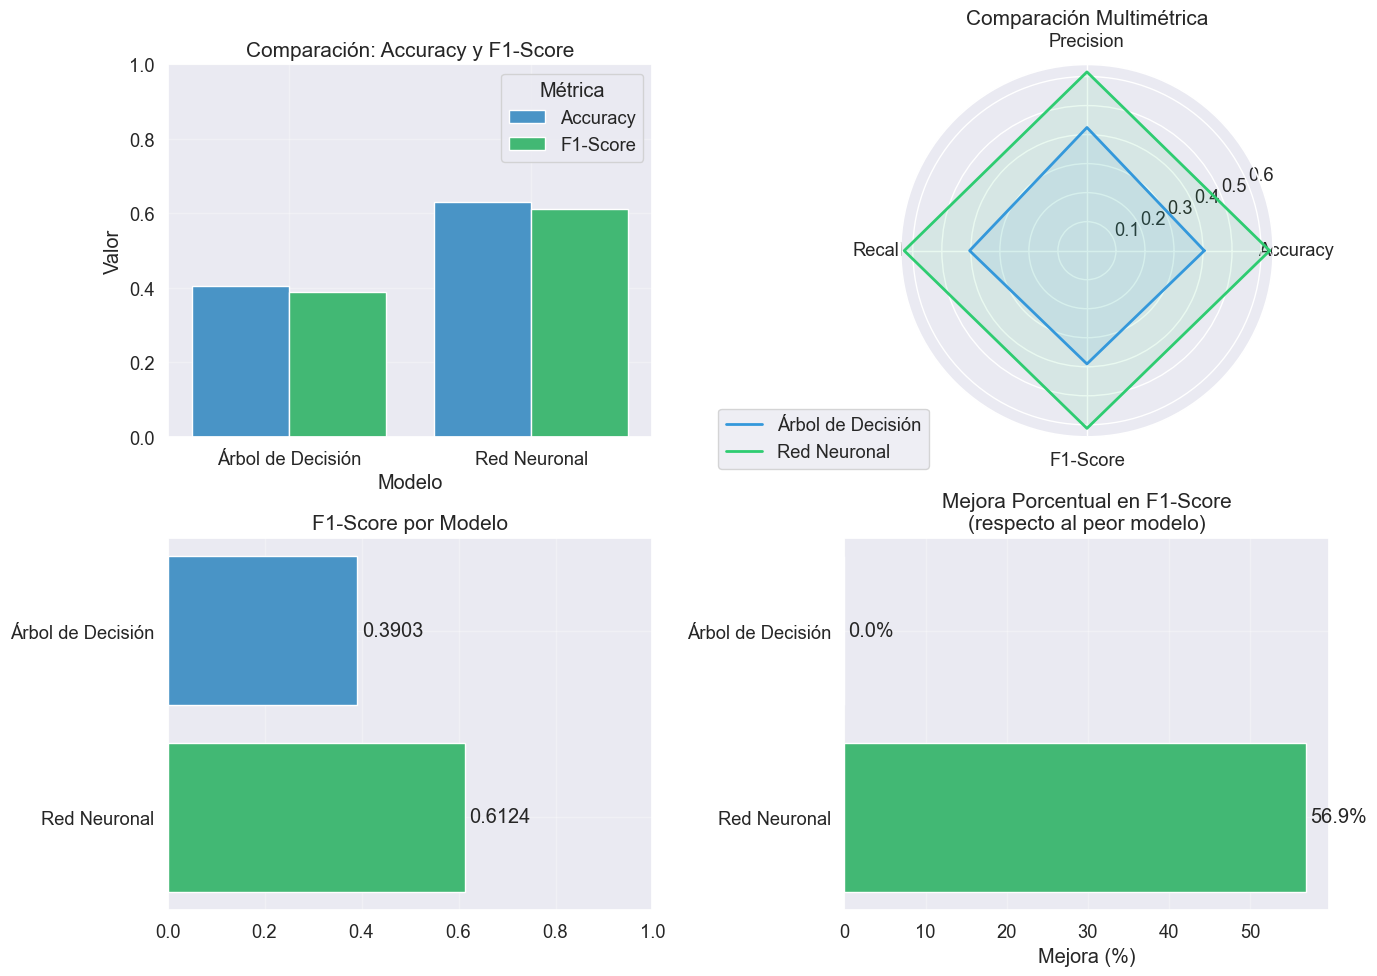

In [57]:
# Datos para la comparación
modelos_nombres = ['Árbol de Decisión', 'Red Neuronal']
accuracy_values = [metricas_dt['accuracy'], metricas_nn['accuracy']]
precision_values = [metricas_dt['precision'], metricas_nn['precision']]
recall_values = [metricas_dt['recall'], metricas_nn['recall']]
f1_values = [metricas_dt['f1'], metricas_nn['f1']]

# Configuración para visualizaciones más atractivas
plt.style.use('ggplot')
sns.set(font_scale=1.2)
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

# Crear figura para la comparación
plt.figure(figsize=(14, 10))

# Subplot 1: Comparación de barras
plt.subplot(2, 2, 1)
df_comp = pd.DataFrame({
    'Modelo': modelos_nombres + modelos_nombres,
    'Métrica': ['Accuracy']*2 + ['F1-Score']*2,
    'Valor': accuracy_values + f1_values
})
sns.barplot(x='Modelo', y='Valor', hue='Métrica', data=df_comp, palette=['#3498db', '#2ecc71'])
plt.title('Comparación: Accuracy y F1-Score', fontsize=15)
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.grid(True, alpha=0.3)

# Subplot 2: Gráfico de radar para comparación multimétrica
plt.subplot(2, 2, 2, polar=True)
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
valores = {
    'Árbol de Decisión': [metricas_dt['accuracy'], metricas_dt['precision'], metricas_dt['recall'], metricas_dt['f1']],
    'Red Neuronal': [metricas_nn['accuracy'], metricas_nn['precision'], metricas_nn['recall'], metricas_nn['f1']]
}

# Número de variables
N = len(metricas)
# Ángulos para cada eje
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Cerrar el polígono

# Crear el gráfico de radar
for i, modelo in enumerate(modelos_nombres):
    valores_modelo = valores[modelo]
    valores_modelo += valores_modelo[:1]  # Cerrar el polígono
    plt.plot(angles, valores_modelo, linewidth=2, linestyle='solid', label=modelo, color=colors[i])
    plt.fill(angles, valores_modelo, color=colors[i], alpha=0.1)

# Configurar el gráfico de radar
plt.xticks(angles[:-1], metricas)
plt.title('Comparación Multimétrica', fontsize=15)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Subplot 3: Gráfico de barras horizontales para F1-Score
plt.subplot(2, 2, 3)
sns.barplot(y=modelos_nombres, x=f1_values, palette=['#3498db', '#2ecc71'], orient='h')
plt.title('F1-Score por Modelo', fontsize=15)
plt.xlim(0, 1)
for i, v in enumerate(f1_values):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center')
plt.grid(True, alpha=0.3)

# Subplot 4: Mejora porcentual respecto al peor modelo
plt.subplot(2, 2, 4)
# Calcular mejora porcentual en F1-Score respecto al peor modelo
peor_f1 = min(f1_values)
mejora_porcentual = [(f1 - peor_f1) / peor_f1 * 100 for f1 in f1_values]

# Crear barras de mejora porcentual
sns.barplot(y=modelos_nombres, x=mejora_porcentual, palette=['#3498db', '#2ecc71'], orient='h')
plt.title('Mejora Porcentual en F1-Score\n(respecto al peor modelo)', fontsize=15)
plt.xlabel('Mejora (%)')
for i, v in enumerate(mejora_porcentual):
    plt.text(v + 0.5, i, f'{v:.1f}%', va='center')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()